<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Rain%20in%20Australia/Rain%20in%20Australia%20-%20Mixed%20Feature%20Type%20%26%20Missing%20Value%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rain in Australia - Mixed Feature Type & Missing Value Example

This notebook demonstrates the **Universal ML Workflow** applied to a binary classification problem with **mixed feature types** (categorical and numerical) and **missing values**.

## Learning Objectives

By the end of this notebook, you will be able to:
- Handle **mixed feature types** (categorical + numerical) in a single model
- Apply appropriate preprocessing: **One-Hot Encoding** for categorical, **Standardization** for numerical
- Handle **missing values** using different strategies (kNN imputation, "Unknown" category)
- Address **class imbalance** using class weights during training
- Build and evaluate a binary classification neural network
- Use Grid Search with Cross-Validation for hyperparameter tuning

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [Kaggle Weather Dataset](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) |
| **Problem Type** | Binary Classification |
| **Target Variable** | RainTomorrow (Yes/No) |
| **Data Balance** | Imbalanced (~78% No, ~22% Yes) |
| **Data Type** | Structured (Mixed Categorical & Numerical) |
| **Missing Data** | Significant missing values in many columns |
| **Features** | 16 numerical + 5 categorical variables |

---

## 1. Defining the Problem and Assembling a Dataset

**Problem Statement:** Given weather observations from various Australian locations, predict whether it will rain tomorrow.

**Why this problem is interesting:**
- Requires handling **mixed feature types** - we have both categorical (Location, WindDirection) and numerical (Temperature, Humidity) features
- Contains **missing values** that must be handled appropriately
- Features **class imbalance** - rain days are less common than non-rain days
- Real-world application: agricultural planning, event scheduling, water resource management

**Data Source:** This dataset contains about 10 years of daily weather observations from numerous Australian weather stations.

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Rain%20in%20Australia/Rain%20in%20Australia%20-%20Mixed%20Feature%20Type%20%26%20Missing%20Value%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rain in Australia - Mixed Feature Type & Missing Value Example

This notebook demonstrates the **Universal ML Workflow** applied to a binary classification problem with mixed feature types and missing values.

## 2. Choosing a Measure of Success

For this imbalanced binary classification problem, we need metrics that account for the class imbalance.

**Metrics we'll use:**

| Metric | Description | Why We Use It |
|--------|-------------|---------------|
| **Balanced Accuracy** | Average of sensitivity and specificity | Not fooled by class imbalance |
| **Precision** | True Positives / (True Positives + False Positives) | How reliable are rain predictions? |
| **Recall** | True Positives / (True Positives + False Negatives) | How many rainy days do we catch? |
| **AUC-ROC** | Area under the ROC curve | Overall discrimination ability |

**Note:** Since missing a rainy day prediction (false negative) might have different costs than a false alarm (false positive), we track both precision and recall.

## 3. Deciding on an Evaluation Protocol

**Evaluation Strategy:**
1. **Hold-out Test Set (15%)**: Reserved for final model evaluation
2. **Validation Set**: Used for early stopping and model monitoring  
3. **K-Fold Cross-Validation (K=5)**: Used during hyperparameter tuning

**Important Considerations:**
- All splits use stratification to maintain the ~78:22 class ratio
- Preprocessing (imputation, encoding, scaling) is fit only on training data to prevent data leakage

## 4. Preparing Your Data

### 4.1 Import Libraries and Set Random Seed

This example requires additional imports for handling missing values (KNNImputer) and mixed data types (ColumnTransformer).

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [396]:
weather = pd.read_csv('weatherAUS.csv')

weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### 4.2 Load and Explore the Dataset

The dataset contains weather observations from various Australian locations. Notice the many NaN (missing) values in several columns.

In [131]:
weather.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [ ]:
weather.describe()

In [138]:
NUMERICAL_VARIABLES = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
                       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

In [140]:
weather.drop(NUMERICAL_VARIABLES, axis=1).describe(include=object)

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


In [142]:
CATEGORICAL_VARIABLES = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [153]:
# Drop rows where target variables are missing or the locations are missing
weather = weather[~weather['RainTomorrow'].isnull() & ~weather['Location'].isnull()]

In [187]:
COLUMNS = CATEGORICAL_VARIABLES + NUMERICAL_VARIABLES

features = weather[COLUMNS]

TARGET_VARIABLE = 'RainTomorrow'
target = weather[TARGET_VARIABLE]

### 4.3 Handle Missing Values

**Missing Value Strategies:**

| Feature Type | Strategy | Rationale |
|--------------|----------|-----------|
| **Numerical** | kNN Imputation | Estimates missing values based on similar observations |
| **Categorical** | Fill with "Unknown" | Creates an explicit category for missing data |

**Why kNN Imputation?** It preserves relationships between features better than simple mean/median imputation.

In [163]:
TEST_SIZE = 0.15

(XF_train, XF_test, 
 yf_train, yf_test) = train_test_split(features, 
                                       target, 
                                       test_size=TEST_SIZE, stratify=target,
                                       shuffle=True, random_state=SEED)

In [165]:
# Imputing missing value for numerical features
knn_imp = KNNImputer(n_neighbors=5).fit(XF_train[NUMERICAL_VARIABLES])

NF_train = knn_imp.transform(XF_train[NUMERICAL_VARIABLES])
NF_test = knn_imp.transform(XF_test[NUMERICAL_VARIABLES])

In [177]:
CF_train = XF_train[CATEGORICAL_VARIABLES].fillna('Unknown')
CF_test = XF_test[CATEGORICAL_VARIABLES].fillna('Unknown')

### 4.4 Preprocessing Pipeline with ColumnTransformer

We use `ColumnTransformer` to apply different preprocessing to different feature types simultaneously:

```
ColumnTransformer
├── Categorical Features → One-Hot Encoding
│   (Creates binary columns for each category)
└── Numerical Features → Standard Scaling
    (Mean=0, Std=1)
```

This is a common pattern for mixed-type datasets.

In [178]:
XC_train = pd.DataFrame(data = np.hstack((NF_train, CF_train)), 
                        columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)

XC_test = pd.DataFrame(data = np.hstack((NF_test, CF_test)), 
                        columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)

In [180]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_VARIABLES),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(XC_train)

In [181]:
X_train, X_test = preprocessor.transform(XC_train), preprocessor.transform(XC_test)

## 5. Developing a Model That Does Better Than a Baseline

### 5.1 Examine Class Distribution and Baselines

In [185]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=VALIDATION_SIZE, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [188]:
counts = weather.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()

counts

RainTomorrow
No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [189]:
baseline = counts.iloc[0] / counts.sum()

baseline

0.7758187815152645

In [408]:
balanced_accuracy_score(y_train, np.zeros(len(y_train)))

0.5

In [191]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [192]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              class_weights,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [193]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [255]:
slp_model = deep_neural_network(hidden_layers=0, 
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1)                 120       
                                                                 
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 512
EPOCHS = 100

In [257]:
weights = compute_class_weight('balanced', classes=np.unique(labels), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 0.6444814234469898, 1: 2.2303262525768575}

In [ ]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

In [259]:
print('Accuracy (Validation): {:.2f} (baseline=0.77)'.format(trained_slp_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.80 (baseline=0.77)
Precision (Validation): 0.54
Recall (Validation): 0.78
AUC (Validation): 0.88


In [409]:
preds = (trained_slp_model['model'].predict(X_val, verbose=0) > 0.5).astype('int32')

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, preds)))

Balanced Accuracy (Validation): 0.79 (baseline = 0.5)


## 6. Scaling Up: Developing a Model That Overfits

Now we increase model capacity to verify the model can learn complex patterns. If it can't overfit, the architecture may be too simple.

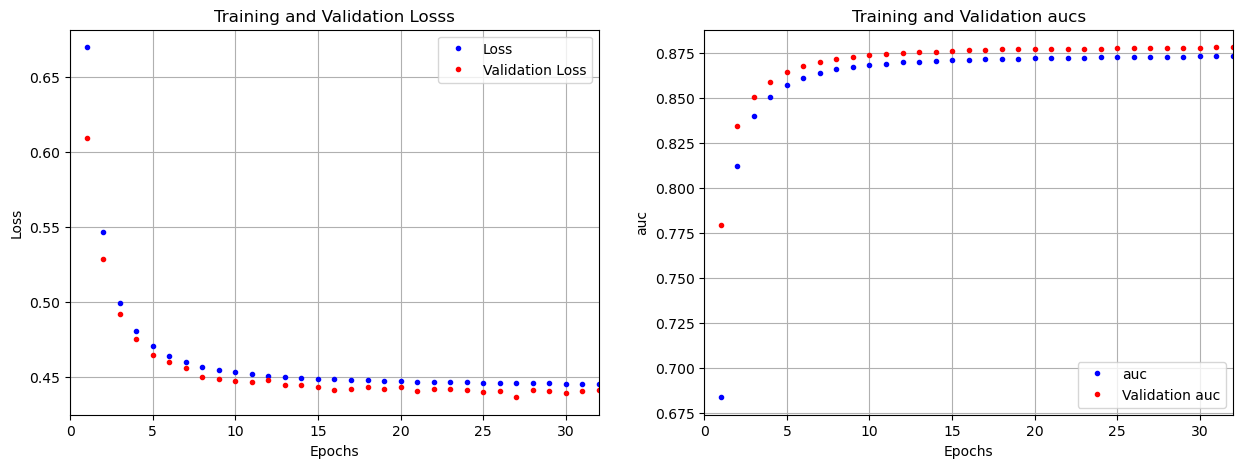

In [415]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [322]:
mlp_model = deep_neural_network(hidden_layers=2, hidden_neurons=80,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 80)                9600      
                                                                 
 dense_67 (Dense)            (None, 80)                6480      
                                                                 
 dense_68 (Dense)            (None, 1)                 81        
                                                                 
Total params: 16,161
Trainable params: 16,161
Non-trainable params: 0
_________________________________________________________________


In [323]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

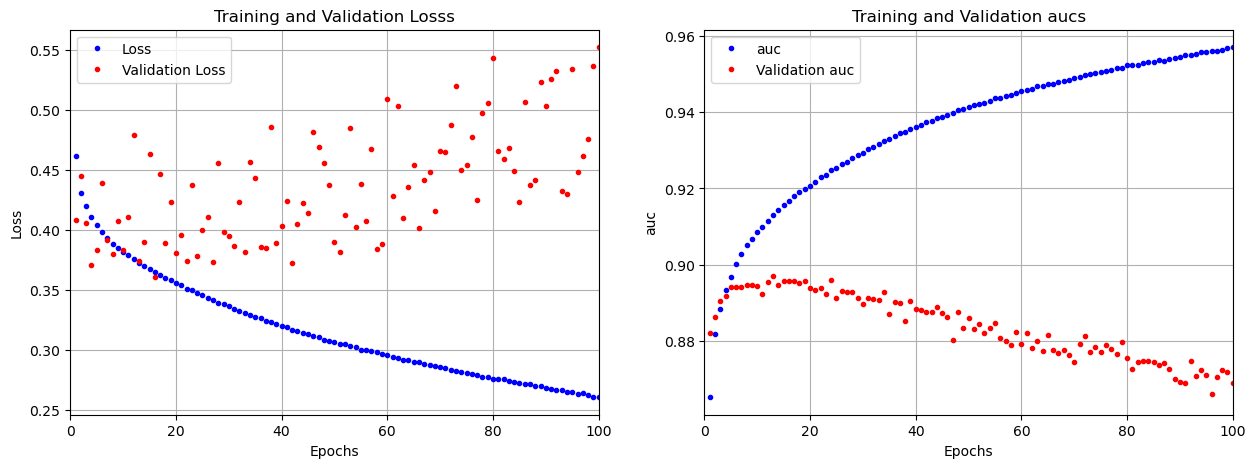

In [414]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

In [410]:
preds = (trained_mlp_model['model'].predict(X_val, verbose=0) > 0.5).astype('int32')

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, preds)))

Balanced Accuracy (Validation): 0.78 (baseline = 0.5)


 ## Regularizing your model and tuning your hyperparameters

In [ ]:
# Hyperband Model Builder for Rain Prediction
def build_model_hyperband(hp):
    """
    Build Rain in Australia model with FROZEN architecture (2 layers: 80 -> 40 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 80 and 40 neurons
    # Layer 1: 80 neurons
    model.add(layers.Dense(80, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 40 neurons
    model.add(layers.Dense(40, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    # Output layer for binary classification
    model.add(layers.Dense(OUTPUT_DIMENSION, activation='sigmoid'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

In [ ]:
# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_auc',
    max_epochs=20,
    factor=3,
    directory='rain_australia_hyperband',
    project_name='rain_australia_tuning'
)

# Run Hyperband search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS
)

In [364]:
KFOLDS = 5

In [416]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,accuracy,precision,recall,auc,balanced_accuracy
1,2,80,relu,0.50,512,26.2,0.393567,0.815924,0.563465,0.795375,0.893613,0.808618
2,3,80,relu,0.25,512,19.4,0.389583,0.813352,0.558821,0.796003,0.892705,0.807184
0,2,80,relu,0.25,512,16.6,0.389708,0.817341,0.566737,0.789012,0.891820,0.807269
3,3,80,relu,0.50,512,16.6,0.403549,0.810348,0.554275,0.787667,0.886370,0.802284


In [398]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [400]:
print('Accuracy (Validation): {:.2f} (baseline=0.77)'.format(trained_opt_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.82 (baseline=0.77)
Precision (Validation): 0.57
Recall (Validation): 0.79
AUC (Validation): 0.90


In [ ]:
# Get best hyperparameters and build best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

opt_model = tuner.hypermodel.build(best_hp)
opt_model.summary()

# Train the best model
history_opt = opt_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

trained_opt_model = {
    'model': opt_model,
    'val_score': opt_model.evaluate(X_val, y_val, verbose=0)[1:],
    'history': history_opt
}

In [412]:
print('Balanced Accuracy (Test): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_test, 
                                                                                               (preds > 0.5).astype('int32'))))

Balanced Accuracy (Test): 0.50 (baseline = 0.5)


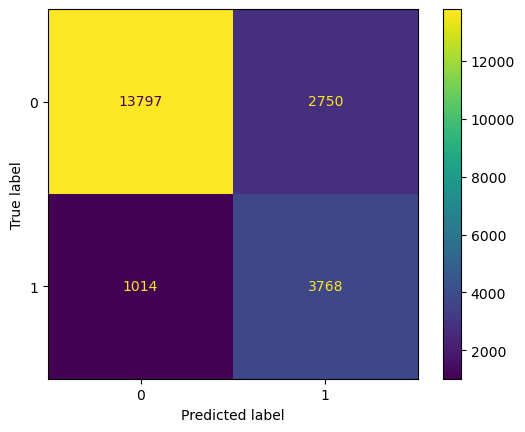

In [404]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')))
_ = disp.plot()